## Download del dataset dalla libreria medmnist

In [ ]:
!pip install medmnist

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier


from medmnist.dataset import ChestMNIST
Dataset = ChestMNIST
dataset = Dataset(split='val', download=True)
label_map = dataset.info['label']

Using downloaded and verified file: /Users/angelolongano/.medmnist/chestmnist.npz


# Informazioni su ChestMNIST
Il ChestMNIST si basa sul set di dati NIH-ChestXray14,  
un set di dati che comprende __112.120 immagini__ radiografiche con vista frontale di 30.805 pazienti unici con __14 etichette__ di malattia estratte dal testo, che potrebbero essere formulate come un compito di classificazione binario multi-label.  
Utilizziamo la suddivisione dei dati ufficiali e ridimensioniamo le immagini di partenza di 1×1024×1024 in __1×28×28__.  
  
Le etichette sono:
- 0: **atelectasis** (atelettasia): collasso del tessuto polmonare con perdita di volume
- 1: **cardiomegaly** (cardiomegalia): aumento del volume o della massa del cuore dovuto ad aumento dello spessore delle sue pareti o a dilatazione abnorme delle sue cavità
- 2: **effusion** (versamento): accumulo anormale di liquido o pus all'interno della cavità pleurica
- 3: **infiltration** (infiltrazione): accumulo di cellule infiammatorie o di altre sostanze all'interno dei tessuti polmonari
- 4: **mass** (massa): formazione anomala di tessuto all'interno dei polmoni
- 5: **nodule** (nodulo): piccola massa o grumo di tessuto all'interno dei polmoni
- 6: **pneumonia** (polmonite): infiammazione dei polmoni causata da un'infezione batterica, virale o fungina
- 7: **pneumothorax** (pneumotorace): presenza di aria nella cavità pleurica che separa i polmoni dalla parete toracica
- 8: **consolidation** (consolidamento): sostituzione dell'aria nei polmoni con liquido o tessuto solido
- 9: **edema** (edema): accumulo di liquido nei tessuti polmonari
- 10: **emphysema** (enfisema): danneggiamento dei piccoli sacchi d'aria (alveoli) nei polmoni
- 11: **fibrosis** (fibrosi): formazione di tessuto cicatriziale fibroso nei polmoni
- 12: **pleural** (pleurite): infiammazione della membrana che riveste i polmoni e la cavità toracica
- 13: **hernia** (ernia): sporgenza di un organo attraverso una debolezza o un difetto nella parete muscolare o nel tessuto che lo contiene

Divisione del dataset:
{'train': 78468, 'val': 11219, 'test': 22433}


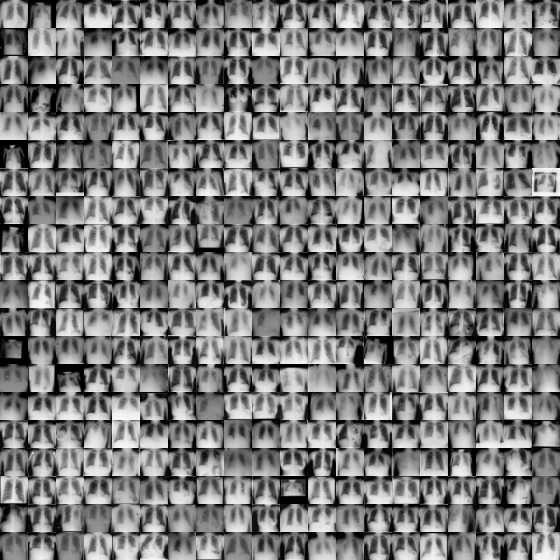

In [3]:
print("Divisione del dataset:")
print(dataset.info['n_samples'])
dataset.montage(20)

# Estrazione del train set e del test set

In [4]:
X_train, Y_train = Dataset(split='train',download=True).imgs, Dataset(split='train',download=True).labels
X_test, Y_test = Dataset(split='test',download=True).imgs, Dataset(split='test',download=True).labels

Using downloaded and verified file: /Users/angelolongano/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/angelolongano/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/angelolongano/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/angelolongano/.medmnist/chestmnist.npz


In [5]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

In [6]:
scaler = StandardScaler().set_output(transform="pandas")

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [7]:
Y_train = np.argmax(Y_train, axis=1)
Y_test = np.argmax(Y_test, axis=1)

In [8]:
Y_train_bin = np.where(Y_train == 0, 0, 1)
Y_test_bin = np.where(Y_test == 0, 0, 1)

In [9]:
# Distribuzione delle classi nel train set
print(pd.Series(Y_train).value_counts())

0     50401
3      9483
2      6445
4      2313
5      2292
7      1935
1      1686
8      1060
12      761
10      676
11      535
9       503
6       307
13       71
Name: count, dtype: int64


In [10]:
# Distribuzione delle classi nel test set
print(pd.Series(Y_test).value_counts())

0     14348
3      2700
2      1832
5       731
4       657
7       539
1       502
8       274
12      247
10      206
11      174
9       116
6        86
13       21
Name: count, dtype: int64


# Minimi Vicini vs Random Forest

## Minimi vicini


In [11]:
grid = GridSearchCV(KNeighborsClassifier(weights='uniform'), {'n_neighbors':[1,10,100,500,1000]}, cv=2)
grid.fit(X_train_scaled, Y_train)
grid.score(X_test_scaled, Y_test)

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 10, 100, 500, 1000]})

In [12]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_n_neighbors","mean_test_score","mean_score_time"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

,RANK_TEST_SCORE,PARAM_N_NEIGHBORS,MEAN_TEST_SCORE,MEAN_SCORE_TIME
3,1,500,"0,64231279","14,95402646"
4,1,1.000,"0,64231279","15,98174453"
2,3,100,"0,64218535","13,66691530"
1,4,10,"0,63490850","13,44181848"
0,5,1,"0,49537391","14,28797221"


(0.0, 20.0)

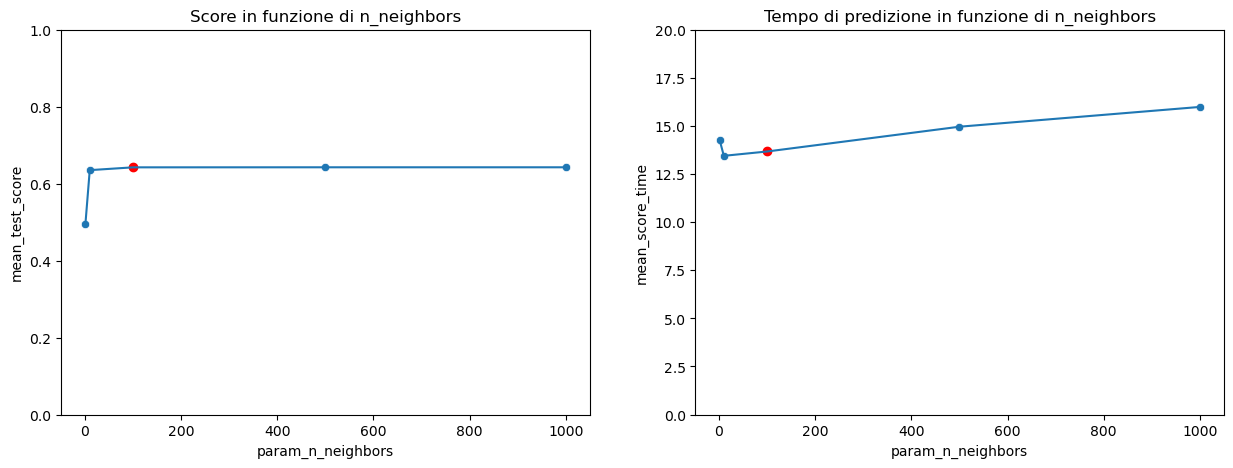

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.lineplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0]).set_title('Score in funzione di n_neighbors')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0])
# visualizza in rosso il miglior modello
best = df.iloc[2]
ax[0].scatter(best.param_n_neighbors, best.mean_test_score, color='red')
ax[0].set_ylim(0,1)

sns.lineplot(data=df, x='param_n_neighbors', y='mean_score_time', ax=ax[1]).set_title('Tempo di predizione in funzione di n_neighbors')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_score_time', ax=ax[1])
ax[1].scatter(best.param_n_neighbors, best.mean_score_time, color='red')
ax[1].set_ylim(0,20)

## Random Forest Classifier

In [14]:
grid = GridSearchCV(RandomForestClassifier(random_state=0), {'n_estimators':[1,10,100],'max_depth':[1,10,50,100]}, cv=2)
grid.fit(X_train_scaled, Y_train)
grid.score(X_test_scaled, Y_test)

0.6395934560691838

In [15]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_n_estimators","param_max_depth","mean_fit_time"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

,RANK_TEST_SCORE,PARAM_N_ESTIMATORS,PARAM_MAX_DEPTH,MEAN_FIT_TIME
0,1,1,1,"0,08097053"
1,1,10,1,"0,31154788"
2,1,100,1,"2,67052400"
5,4,100,10,"25,84328437"
11,5,100,100,"69,32012749"
8,6,100,50,"68,51906931"
4,7,10,10,"2,59789526"
7,8,10,50,"6,85441160"
10,9,10,100,"6,91572440"
3,10,1,10,"0,30009103"


## LDA 2D

In [16]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_scaled, Y_train)
X_test_lda = lda.transform(X_test_scaled)

<Axes: xlabel='lda1', ylabel='lda2'>

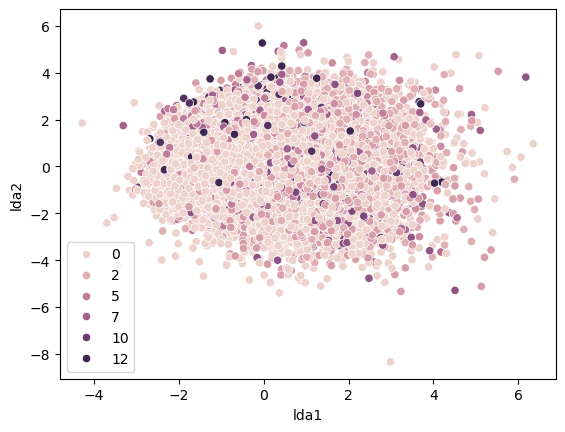

In [17]:
sns.scatterplot(data=pd.DataFrame(X_train_lda, columns=['lda1','lda2']), x='lda1', y='lda2', hue=Y_train)

Text(0.5, 1.0, 'Classificazione multiclasse')

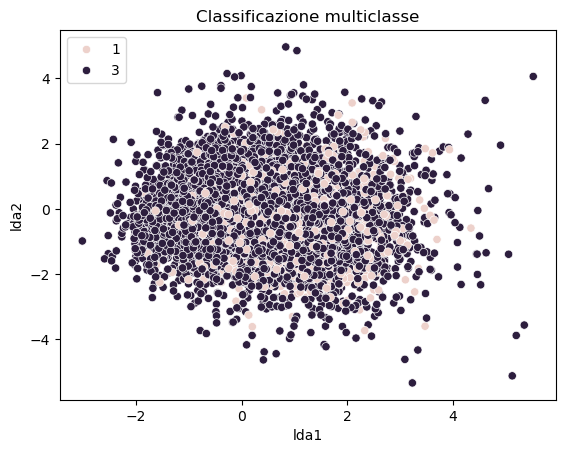

In [18]:
idx0 = Y_train== 1
idx1 = Y_train== 3

Y_train_filtered = Y_train[idx0 | idx1]
X_train_lda_filtered= X_train_lda[idx0 | idx1]

sns.scatterplot(data=pd.DataFrame(X_train_lda_filtered, columns=['lda1','lda2']), x='lda1', y='lda2', hue=Y_train_filtered).set_title('Classificazione multiclasse')

## LDA 3D

In [19]:
lda3 = LinearDiscriminantAnalysis(n_components=3)
X_train_lda3 = lda3.fit_transform(X_train_scaled, Y_train)
X_test_lda3 = lda3.transform(X_test_scaled)

Text(0.5, 0, 'lda3')

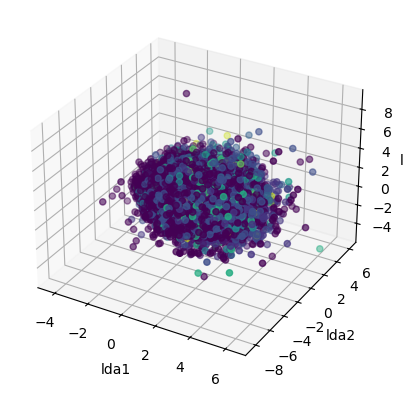

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_lda3[:,0], X_train_lda3[:,1], X_train_lda3[:,2], c=Y_train)
ax.set_xlabel('lda1')
ax.set_ylabel('lda2')
ax.set_zlabel('lda3')

### LDA 3D con minimi vicini

In [21]:
grid = GridSearchCV(KNeighborsClassifier(), {'n_neighbors':[1,10,100,500]}, cv=2)
grid.fit(X_train_lda3, Y_train)
grid.score(X_test_lda3, Y_test)
print("Miglior modello: ", grid.best_params_)
print("Miglior score: ", grid.best_score_)

Miglior modello:  {'n_neighbors': 500}
Miglior score:  0.642312789927104


In [22]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_n_neighbors","mean_test_score","mean_score_time"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

,RANK_TEST_SCORE,PARAM_N_NEIGHBORS,MEAN_TEST_SCORE,MEAN_SCORE_TIME
3,1,500,"0,64231279","2,70420074"
2,2,100,"0,64222358","0,86585701"
1,3,10,"0,63009125","0,48214114"
0,4,1,"0,46685273","0,36275697"


(0.0, 5.0)

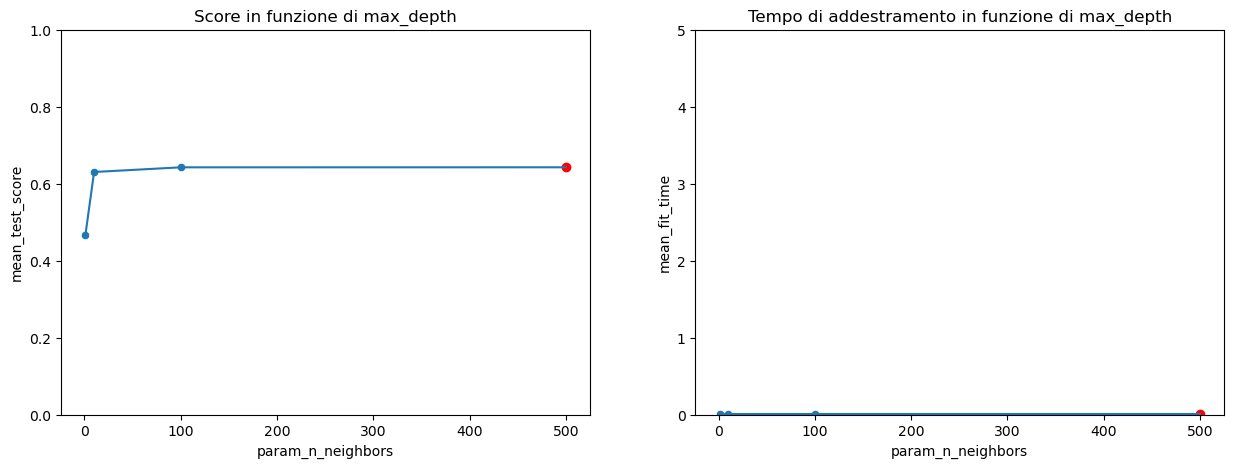

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.lineplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0]).set_title('Score in funzione di max_depth')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0])
# visualizza in rosso il miglior modello
best = df.iloc[0]
ax[0].scatter(best.param_n_neighbors, best.mean_test_score, color='red')
ax[0].set_ylim(0,1)

sns.lineplot(data=df, x='param_n_neighbors', y='mean_fit_time', ax=ax[1]).set_title('Tempo di addestramento in funzione di max_depth')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_fit_time', ax=ax[1])
ax[1].scatter(best.param_n_neighbors, best.mean_fit_time, color='red')
ax[1].set_ylim(0,5)

### LDA 3D con Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

grid = GridSearchCV(RandomForestClassifier(), {'n_estimators':[1],'max_depth':[1,5,10,25,50,75,100]}, cv=2)
grid.fit(X_train_scaled, Y_train)
grid.score(X_test_scaled, Y_test)
print("Miglior modello: ", grid.best_params_)
print("Miglior score: ", grid.best_score_)

Miglior modello:  {'max_depth': 1, 'n_estimators': 1}
Miglior score:  0.642312789927104


In [25]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_max_depth","mean_test_score","mean_fit_time"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

,RANK_TEST_SCORE,PARAM_MAX_DEPTH,MEAN_TEST_SCORE,MEAN_FIT_TIME
0,1,1,"0,64231279","0,08286095"
1,2,5,"0,64176480","0,16069114"
2,3,10,"0,60813325","0,28236508"
3,4,25,"0,48630015","0,59920144"
5,5,75,"0,44432125","0,69421315"
6,6,100,"0,44307234","20,10957599"
4,7,50,"0,44248611","0,68380845"


(0.0, 1.0)

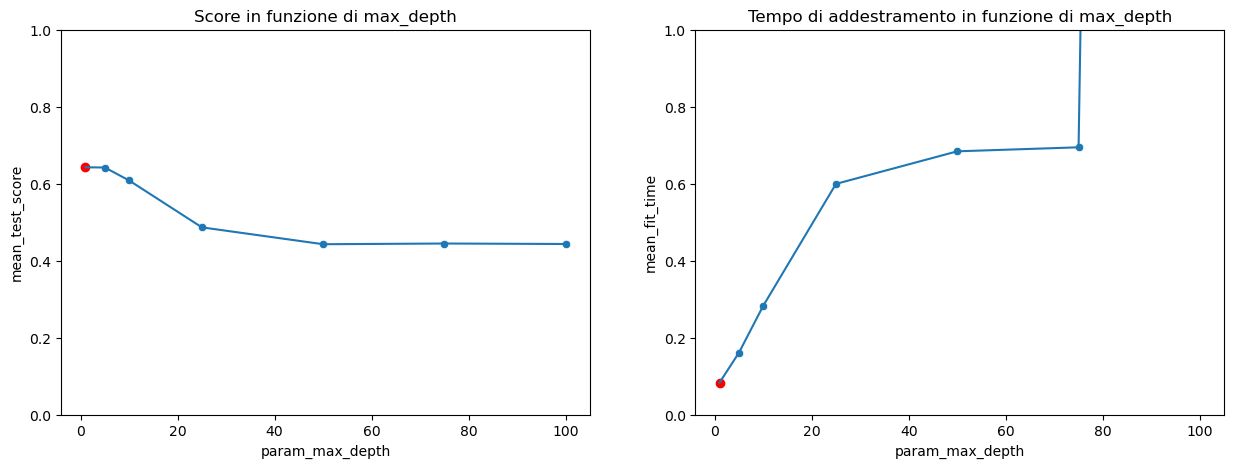

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.lineplot(data=df, x='param_max_depth', y='mean_test_score', ax=ax[0]).set_title('Score in funzione di max_depth')
sns.scatterplot(data=df, x='param_max_depth', y='mean_test_score', ax=ax[0])
# visualizza in rosso il miglior modello
best = df.iloc[0]
ax[0].scatter(best.param_max_depth, best.mean_test_score, color='red')
ax[0].set_ylim(0,1)

sns.lineplot(data=df, x='param_max_depth', y='mean_fit_time', ax=ax[1]).set_title('Tempo di addestramento in funzione di max_depth')
sns.scatterplot(data=df, x='param_max_depth', y='mean_fit_time', ax=ax[1])
ax[1].scatter(best.param_max_depth, best.mean_fit_time, color='red')
ax[1].set_ylim(0,1)

# Classificazione multipla

## Majority vote rule

In [27]:
cls = VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=100)),('rf', RandomForestClassifier(n_estimators=1, max_depth=1))])
cls.fit(X_train_scaled, Y_train)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=100)),
                             ('rf',
                              RandomForestClassifier(max_depth=1,
                                                     n_estimators=1))])

In [28]:
cls.score(X_test_scaled, Y_test)

0.6395934560691838

## Uno contro Tutti

In [29]:
cls = OneVsRestClassifier(RandomForestClassifier(n_estimators=1, max_depth=1))
cls.fit(X_train_scaled, Y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=1,
                                                     n_estimators=1))

In [30]:
cls.score(X_test_scaled, Y_test)

0.6395934560691838

## Uno contro uno

In [31]:
cls = OneVsOneClassifier(RandomForestClassifier(n_estimators=1, max_depth=1))
cls.fit(X_train_scaled, Y_train)

OneVsOneClassifier(estimator=RandomForestClassifier(max_depth=1,
                                                    n_estimators=1))

In [32]:
cls.score(X_test_scaled, Y_test)

0.6395934560691838

# Conclusioni